In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import quantstats as qs

%config InlineBackend.figure_format = "retina"

In [59]:
def cache(func):
    def wrapped_func(*args, **kwargs):
        table_name = func.__name__.split("_")[-1]
        parquet_path = f"./data/{table_name}.parquet"
        try:
            table = pd.read_parquet(parquet_path)
        except FileNotFoundError:
            table = func(*args, **kwargs)
            table.to_parquet(parquet_path)
        return table

    return wrapped_func

def query(sql_stmt, params, wrds_username):
    import wrds

    with wrds.Connection(wrds_username=wrds_username) as db:
        data = db.raw_sql(sql_stmt, date_cols=["date"], params=params)
    return data

def get_crsp(permnos, wrds_username):
    sql_crsp = """
    SELECT
        date,
        permno,
        openprc AS open,
        askhi AS high,
        bidlo AS low,
        prc AS close,
        vol AS volume,
        ret,
        shrout
    FROM
        crsp.dsf
    WHERE
        permno IN %(permnos)s
        AND date >= '1997-01-01'
        AND date <= '2019-12-31'
    ORDER BY
        date, permno;
    """
    params = {"permnos": permnos}
    crsp = query(sql_crsp, params, wrds_username).astype({"permno":"category"}).convert_dtypes()
    # Fill missing close prices of permno 80539
    crsp.loc[crsp.permno == 80539, "close"] = crsp.loc[crsp.permno == 80539, "close"].fillna(method="bfill")
    # Fill other missing values
    crsp = crsp.fillna({"open": crsp.close,
        "high": crsp.close,
        "low": crsp.close,
        "volume": 0,
        "ret": 0})
    # Calculate market capitalization
    crsp["cap"] = crsp.close * crsp.shrout
    # Shift market capitalization to avoid look ahead bias
    crsp["cap"] = crsp.groupby("permno").cap.shift(1)
    # Calculate market capiticalization weight
    crsp["w_cap"] = crsp.groupby("date").cap.apply(lambda x: x / x.sum())
    # Convert certain data types to float64
    crsp = crsp.astype({"ret":"float"})
    return crsp

def get_fama_french():
    """
    Get 3-factor and momentum data from Ken French data library.
    """
    import pandas_datareader as web

    # Transfrom from percentage to nominal value
    factor = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start="1997-01-01", end="2019-12-31")[0]/100
    momentum = web.DataReader("F-F_Momentum_Factor_daily", "famafrench", start="1997-01-01", end="2019-12-31")[0]/100
    # Merge into 4 factor model
    fama_french = pd.concat([factor, momentum], axis=1)
    fama_french = fama_french.rename(columns=lambda x: x.lower().strip().replace("-", "")).rename_axis(index=str.lower)
    return fama_french

## Benchmark

In [4]:
path = Path("./data")
permno_path = path/"permno_selection.csv"
permnos = pd.read_csv(permno_path, dtype={"permno":"str"}).squeeze().pipe(tuple)
crsp = get_crsp(permnos, "iewaij")

Loading library list...
Done


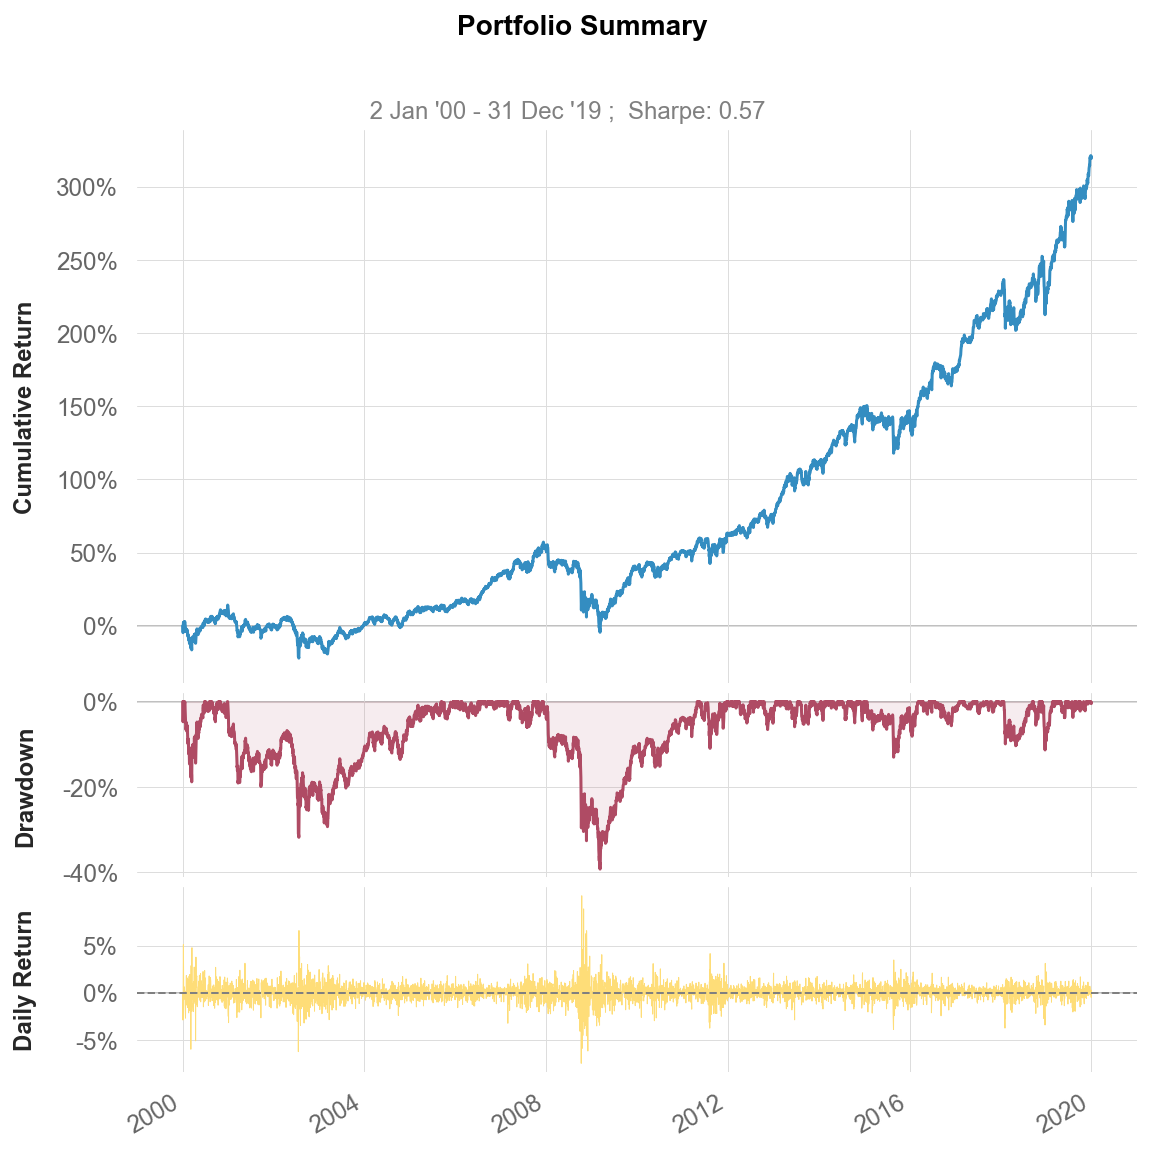

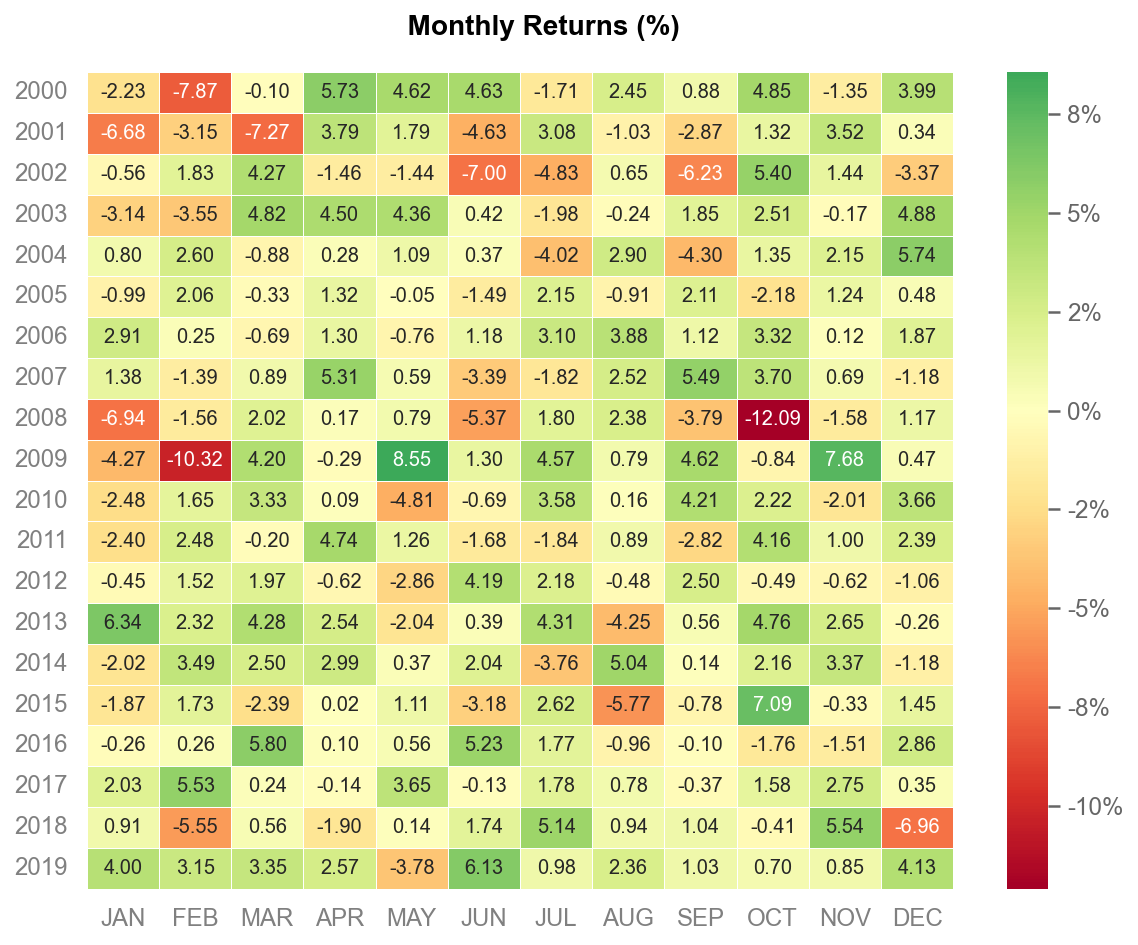

In [5]:
bnch_ret = (crsp.ret * crsp.w_cap).groupby(crsp.date).sum()
bnch_ret = bnch_ret.loc["2000-01-01":"2019-12-31"]
qs.reports.plots(bnch_ret)